In [1]:
# setup imports
import os
import sys
import pathlib
import utility

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
from PIL import Image

import tensorflow as tf
# if there is a GPU, enable memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
   tf.config.experimental.set_memory_growth(gpus[0], True)

tf.__version__

'2.1.0'

In [2]:
# setup labels
labels = [
    'wall',
    'floor',
    'cabinet',
    'bed',
    'chair',
    'sofa',
    'table',
    'door',
    'window',
    'bookshelf',
    'picture',
    'counter',
    'blinds',
    'desk',
    'shelves',
    'curtain',
    'dresser',
    'pillow',
    'mirror',
    'floor_mat',
    'clothes',
    'ceiling',
    'books',
    'fridge',
    'tv',
    'paper',
    'towel',
    'shower_curtain',
    'box',
    'whiteboard',
    'person',
    'night_stand',
    'toilet',
    'sink',
    'lamp',
    'bathtub',
    'bag'
]

# setup dataset
dataset_dir = pathlib.Path() / "dataset"

train_dir = dataset_dir / "train"
test_dir = dataset_dir / "test"
val_dir = dataset_dir / "val"

checkpoint_path = dataset_dir / "checkpoints" / "resnetV50"
log_path = dataset_dir / "logs"

def count_elems(dir_):
    return len(list((dir_/'rgb').iterdir()))

train_len = count_elems(train_dir)
test_len = count_elems(test_dir)
val_len = count_elems(val_dir)

list(zip(
    ('train', 'validation', 'test'),
    (train_len, val_len, test_len)
))

[('train', 7234), ('validation', 1033), ('test', 2068)]

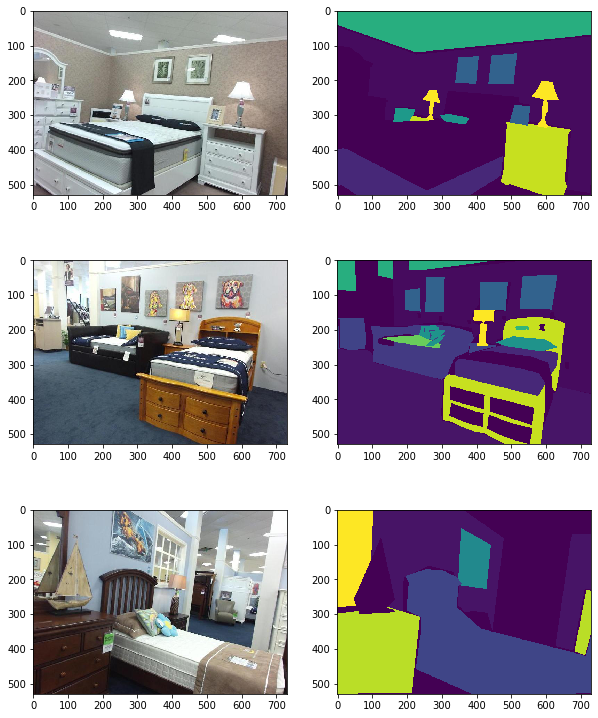

In [3]:
images = list(test_dir.glob('rgb/*'))
segments = list(test_dir.glob('seg/*'))
n = 3

fig, axes = plt.subplots(n, 2)
fig.set_figheight(13)
fig.set_figwidth(10)

for i, (img, seg) in enumerate(zip(images[:n], segments[:n])):
    axes[i, 0].imshow(Image.open(str(img)))
    axes[i, 1].imshow(Image.open(str(seg)))

In [4]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator()

TRAIN_LENGTH = count_elems(train_dir)
BUFFER_SIZE = 1000
BATCH_SIZE = 16
IMG_HEIGHT = 512
IMG_WIDTH = 512
STEPS_PER_EPOCH = np.ceil(train_len/BATCH_SIZE)


In [5]:
def parse_image(img_path):
    # print("img_path - {}".format(img_path))
    if not isinstance(img_path, pathlib.Path):
        raise ValueError('Passare un pathlib alla funzione')

    image = tf.io.read_file(str(img_path))
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    mask_path = pathlib.Path(img_path.parent) / (img_path.stem + '.png')
    #mask_path = tf.strings.regex_replace(img_path, "rgb", "seg")
    #mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")

    mask = tf.io.read_file(str(mask_path))
    mask = tf.image.decode_png(mask, channels=1)
    # mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)

    return {'image': image, 'mask': mask}

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [64]:
image_glob = lambda p: str((p / 'rgb').resolve()) + '/*.jpg'

train_dataset = tf.data.Dataset.list_files(image_glob(train_dir), seed=0)
# train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(image_glob(val_dir), seed=0)
#val_dataset = val_dataset.map(parse_image)

test_dataset = tf.data.Dataset.list_files(image_glob(test_dir), seed=0)
#test_dataset = test_dataset.map(parse_image)

dataset = {"train": train_dataset, "val": val_dataset, "test": test_dataset}


TypeError: Invalid shape (512, 512, 1) for image data

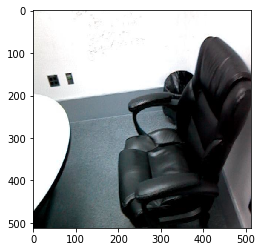

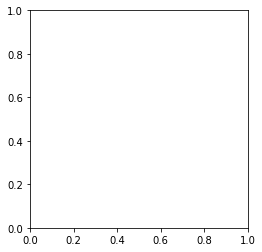

In [51]:
import cv2
import random

def data_generator(folder, batch_size=16):
    images = list((folder / 'rgb').iterdir())
    masks = list((folder / 'seg').iterdir())
    tuples = list(zip(images, masks))
    random.shuffle(tuples)

    start = 0
    WIDTH, HEIGHT = 512, 512

    while True:
        images = np.zeros((batch_size, WIDTH, HEIGHT, 3)).astype('float')
        masks = np.zeros((batch_size, WIDTH, HEIGHT, 1)).astype('uint')

        for i in range(batch_size):
            # permette di generare all'infinito
            if i + start >= len(tuples):
                start = 0
                random.shuffle(tuples)
            image, mask = tuples[i + start]

            image = cv2.imread(str(image)) / 255.0
            image = cv2.resize(image, (WIDTH, HEIGHT))
            images[i] = image

            mask = cv2.imread(str(mask), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (WIDTH, HEIGHT))
            mask = mask.reshape((WIDTH, HEIGHT, 1))
            mask -= 1
            masks[i] = mask

            '''
            image = tf.io.read_file(str(image))
            image = tf.image.decode_jpeg(image, channels=3)
            #image = tf.image.convert_image_dtype(image, tf.uint8)
            image = tf.cast(image, tf.float32) / 255.0
            images.append(image)

            mask = tf.io.read_file(str(mask))
            mask = tf.image.decode_png(mask, channels=1)
            mask = tf.image.convert_image_dtype(mask, tf.uint8)
            mask = tf.reshape(mask, )
            mask -= 1
            masks.append(mask)
            '''

        start += batch_size
        yield images, masks

BATCH_SIZE = 16

train_gen = data_generator(train_dir, BATCH_SIZE)
test_gen = data_generator(test_dir, BATCH_SIZE)
val_gen = data_generator(val_dir, BATCH_SIZE)

images, masks = next(data_generator(train_dir, batch_size=1))
cnt = 0
plt.imshow(images[cnt])
plt.figure()
plt.imshow(masks[cnt])


In [48]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)
img_gen.flow_from_directory()

TypeError: flow_from_directory() missing 1 required positional argument: 'directory'

In [80]:
import cv2

def data_gen(img_folder, mask_folder, batch_size):
    c = 0
    images = os.listdir(img_folder)

    while True:
        img = np.zeros((batch_size, 512, 512, 3)).astype('float')
        mask = np.zeros((batch_size, 512, 512, 1)).astype('float')

        for i in range(c, c + batch_size):
            image = images[i]
            mask = image.replace('.jpg', '.png')

            train_img = cv2.imread(img_folder+'/'+image)/255.
            train_img = cv2.resize(train_img, (512, 512, 3))

            img[i-c] = train_img

            train_mask = cv2.imread(
                mask_folder+'/'+mask,
                cv2.IMREAD_GRAYSCALE)/255.
            train_mask = cv2.resize(train_mask, (512, 512))
            train_mask = train_mask.reshape(512, 512, 1)

            mask[i-c] = train_mask

            c += batch_size
            if c + batch_size >= len(images):
                c = 0
                yield img, mask
                raise StopIteration
        yield img, mask

BATCH_SIZE = 16

train_gen = data_gen(
    img_folder=str(train_dir / 'rgb'),
    mask_folder=str(train_dir / 'seg'),
    batch_size=BATCH_SIZE
)

val_gen = data_gen(
    img_folder=str(val_dir / 'rgb'),
    mask_folder=str(val_dir / 'seg'),
    batch_size=BATCH_SIZE
)

test_gen = data_gen(
    img_folder=str(test_dir / 'rgb'),
    mask_folder=str(test_dir / 'seg'),
    batch_size=BATCH_SIZE
)


TypeError: Unsupported return value from function passed to Dataset.map(): <generator object tuple_generator at 0x000001FC9A817148>.

In [10]:
def down_block(n_filter, kernel, act="relu", dropout_rate=0.1):
  result = tf.keras.Sequential()
  initializer = tf.random_normal_initializer(0., 0.02)

  result.add(tf.keras.layers.Conv2D(n_filter, (kernel, kernel), activation=act, kernel_initializer=initializer,padding='same'))
  #result.add(tf.keras.layers.Dropout(dropout_rate))
  result.add(tf.keras.layers.Conv2D(n_filter, (kernel, kernel), activation=act, kernel_initializer=initializer,padding='same'))
  result.add(tf.keras.layers.BatchNormalization(axis=3, scale=False))
  result.add(tf.keras.layers.MaxPooling2D((2, 2)))

  return result

def up_block(n_filter, kernel, act="relu", dropout_rate=0.2):
  result = tf.keras.Sequential()
  initializer = tf.random_normal_initializer(0., 0.02)

  result.add(tf.keras.layers.UpSampling2D((2, 2)))
  result.add(tf.keras.layers.Conv2D(n_filter, (kernel, kernel), activation=act, kernel_initializer=initializer,padding='same'))
  #result.add(tf.keras.layers.Dropout(dropout_rate))
  result.add(tf.keras.layers.Conv2D(n_filter, (kernel, kernel), activation=act, kernel_initializer=initializer, padding='same'))
  #result.add(tf.keras.layers.BatchNormalization(axis=3, scale=False))
  return result

def down_block_2(n_filter, kernel, act="relu", dropout_rate=0.1):
  result = tf.keras.Sequential()
  initializer = tf.random_normal_initializer(0., 0.02)

  result.add(tf.keras.layers.Conv2D(n_filter, (kernel, kernel), padding='same', kernel_initializer=initializer))
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.Activation(act))
  result.add(tf.keras.layers.Conv2D(n_filter, (kernel, kernel), padding='same', kernel_initializer=initializer))
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.Activation(act))
  result.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

  return result

def up_block_2(n_filter, kernel, act="relu", dropout_rate=0.2):
  result = tf.keras.Sequential()
  initializer = tf.random_normal_initializer(0., 0.02)

  #result.add(tf.keras.layers.Conv2DTranspose(n_filter, (2, 2), strides=(2, 2), padding='same'))
  result.add(tf.keras.layers.UpSampling2D((2, 2)))
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.Activation(act))
  result.add(tf.keras.layers.Conv2D(n_filter, (kernel, kernel), padding='same', kernel_initializer=initializer))
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.Activation(act))
  result.add(tf.keras.layers.Conv2D(n_filter, (kernel, kernel), padding='same', kernel_initializer=initializer))
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.Activation(act))

  return result

OUTPUT_CHANNELS = 37
base_model = tf.keras.applications.ResNet50V2(input_shape=[128, 128, 3], include_top=False, classes=OUTPUT_CHANNELS)
# Use the activations of these layers
layer_names = [
    'conv1_conv', #64x64
    'conv2_block3_1_relu',   # 32x32
    'conv3_block4_1_relu',   # 16x16
    'conv4_block6_1_relu',   # 8x8
    'conv5_block3_2_relu',  # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

up_stack = [
    up_block(512,3, act="relu"), # 4x4 -> 8x8
    up_block(256,3, act="relu"), # 8x8 -> 16x16
    up_block(128,3, act="relu"), # 16x16 -> 32x32
    up_block(64,3, act="relu"), # 32x32 -> 64x64
    up_block(32,3, act="relu"), # 64x64 -> 128x128
    up_block(16,3, act="relu"), # 128x128 -> 256x256
    up_block(8,3, act="relu"), # 256x256 -> 512x512
]

def unet_model(input_shape, output_channels, ds, us):
  print("UNET MODEL")
  inputs = tf.keras.layers.Input(shape=[input_shape[0], input_shape[1], 3])
  x = inputs
  #x = tf.keras.applications.resnet_v2.preprocess_input(x)
  x = down_block_2(3,3, act="relu")(x)
  first_layer = x
  x = down_block_2(3,3, act="relu")(x)

  # Downsampling through the model
  skips = ds(x)
  skips = [x] + skips#.insert(0,x)
  skips = [first_layer] + skips  #.insert(0,first_layer)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(us, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3,
      strides=2,
      padding='same',
      activation="softmax")

  #last_up = last_up(x)
  #last = tf.keras.layers.Conv2D(output_channels, (3, 3), activation="relu", padding='same')(last_up)
  #last_up = tf.keras.layers.UpSampling2D((2, 2))(x)
  #last = tf.keras.layers.Conv2D(output_channels, (3, 3), activation="softmax", padding='same')(last_up)
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

94674944/94668760 [==============================] - 175s 2us/step

In [54]:
NO_OF_TRAINING_IMAGES = train_len
NO_OF_VAL_IMAGES = val_len

NO_OF_EPOCHS = 30

weights_path = str(dataset_dir / 'checkpoints')

#m = tf.keras.applications.VGG16()
SIZE = (512,512)
model = unet_model(SIZE, OUTPUT_CHANNELS, down_stack, up_stack)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=[tf.keras.metrics.MeanIoU(37)]
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(weights_path)
csv_logger = tf.keras.callbacks.CSVLogger(
    str(dataset_dir / 'logs' / 'log.out'), append=True, separator=';'
)

callbacks_list = [checkpoint, csv_logger]

results = model.fit(
    train_gen,
    epochs=NO_OF_EPOCHS,
    steps_per_epoch=NO_OF_TRAINING_IMAGES//BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=NO_OF_VAL_IMAGES//BATCH_SIZE,
    callbacks=callbacks_list
)

model.save('Model.h5')

UNET MODEL
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 452 steps, validate for 64 steps
Epoch 1/30
  1/452 [..............................] - ETA: 6:50:55WARNING:tensorflow:From C:\Users\Cristiano\anaconda3\envs\ipcv_gpu\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: dataset\checkpoints\assets
  1/452 [..............................] - ETA: 11:24:10

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[16,37,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Neg_2 (defined at <ipython-input-54-f2f53be0c42e>:31) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[metrics/mean_io_u_11/confusion_matrix/assert_non_negative_1/assert_less_equal/Assert/AssertGuard/pivot_f/_12/_33]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[16,37,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Neg_2 (defined at <ipython-input-54-f2f53be0c42e>:31) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_68882]

Function call stack:
distributed_function -> distributed_function
